# Handwritten Digit Classification by CNN and Neural Networks
## STAT-6289
## HW-2

#### Chengyi Yang
#### G 41160789


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data

#### Define the Trainset and Testset. The dataset was splited randomly to the trainset and test set. 

#### Here we using the SEMEION dataset.

In [2]:
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))],)


batch_size = 40

dataset = torchvision.datasets.SEMEION(root='./data', 
                                      download=True, transform=transform)

trainset, testset = torch.utils.data.random_split(dataset, [1000,593])


# Load the trainset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Load the testset
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('0' , '1' , '2' , '3' , '4' , '5' , '6' , '7' , '8' , '9')

Files already downloaded and verified


#### Let us show some of the training images.

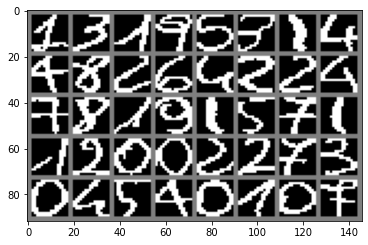

1     3     1     9     5     3     1     4     4     8     2     6     4     2     2     4     7     8     1     9     1     5     7     1     1     2     0     0     2     2     7     3     0     4     5     4     0     1     0     7    


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Model 1: CNN model with 1 Convolutional layer and SGD as optimizer.

In [4]:

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(4 * 7 * 7, 180)
        self.fc2 = nn.Linear(180, 90)
        self.fc3 = nn.Linear(90, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net_1 = Net()
net_1 = net_1.to ('cuda')

# Define a Loss function and optimizer
# Let’s use a Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_1.parameters(), lr=0.001, momentum=0.9)

In [5]:
n_epochs = 80
all_acc_1 = []
train_acc_1 = []
for epoch in range(n_epochs):  # loop over the dataset multiple times
    net_1.to('cuda')
    net_1.train()
    running_loss = 0.0
    train_accs=[]
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        accs = (outputs.argmax(dim=-1) == labels.to('cuda')).float().mean()
        train_accs.append(accs)
    train_acc = sum(train_accs) / len(train_accs)
    train_acc_1.append(train_acc.cpu().item())
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] , Accuracy of Training data = {train_acc:.5f}")
            
    net_1.eval()
    net_1.cpu()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net_1(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_1.append(acc)
    print(f'Accuracy of Test data = {100 * correct // total} %')
print('Finished Training')

[ Train | 001/080 ] , Accuracy of Training data = 0.11300
Accuracy of Test data = 10 %
[ Train | 002/080 ] , Accuracy of Training data = 0.12300
Accuracy of Test data = 10 %
[ Train | 003/080 ] , Accuracy of Training data = 0.12000
Accuracy of Test data = 10 %
[ Train | 004/080 ] , Accuracy of Training data = 0.12700
Accuracy of Test data = 11 %
[ Train | 005/080 ] , Accuracy of Training data = 0.13000
Accuracy of Test data = 12 %
[ Train | 006/080 ] , Accuracy of Training data = 0.14400
Accuracy of Test data = 14 %
[ Train | 007/080 ] , Accuracy of Training data = 0.17400
Accuracy of Test data = 17 %
[ Train | 008/080 ] , Accuracy of Training data = 0.20200
Accuracy of Test data = 19 %
[ Train | 009/080 ] , Accuracy of Training data = 0.23300
Accuracy of Test data = 21 %
[ Train | 010/080 ] , Accuracy of Training data = 0.27200
Accuracy of Test data = 26 %
[ Train | 011/080 ] , Accuracy of Training data = 0.33000
Accuracy of Test data = 31 %
[ Train | 012/080 ] , Accuracy of Training 

Show the plot fo Training and Test Accuracy in Model 1

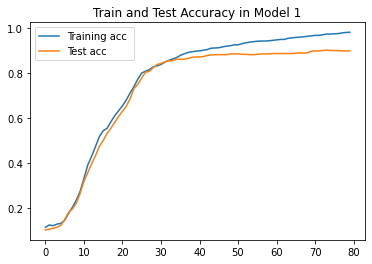

In [6]:
plt.plot(train_acc_1)
plt.plot(all_acc_1)
plt.legend(['Training acc ','Test acc'])
plt.title('Train and Test Accuracy in Model 1')
plt.show()

In [7]:
PATH1 = './cifar_net.pth'
torch.save(net_1.state_dict(), PATH1)

Show some images and their predicted value

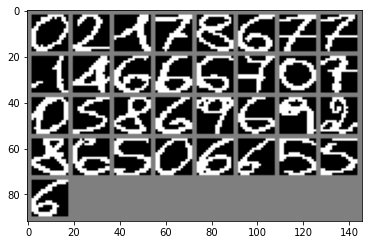

Predicted:  0     2     1     7     8     6     7     7     1     4     6     6     6     7     0     7     0     5     8     6     9     6     9     2     8     6     5     0     6     2     3     5     6    


In [8]:
net_1 = Net()
net_1.load_state_dict(torch.load(PATH1))

outputs = net_1(images)

_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images))

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(predicted.size(dim=0))))


Show the Accuracy of Model 1 and Accuracy in each class.

In [9]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net_1(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of Net_1 on all test images: {100 * correct // total} %')

Accuracy of Net_1 on all test images: 89 %


In [10]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_1(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 100.0 %
Accuracy for class: 1     is 83.9 %
Accuracy for class: 2     is 93.6 %
Accuracy for class: 3     is 85.7 %
Accuracy for class: 4     is 91.2 %
Accuracy for class: 5     is 83.3 %
Accuracy for class: 6     is 92.6 %
Accuracy for class: 7     is 94.7 %
Accuracy for class: 8     is 91.7 %
Accuracy for class: 9     is 82.3 %


##### Conclusion of Model 1

The accuracy of both the Training data and Test data are high. 

The accuray for Class '0' is 100%, highest. And the accuracy of Class '9' is the lowest, only 82.3%, lowest.

It seems a good Model to using. 

But I wang to approve it by several ways. For example, using only Simple neural network, add number of conv layers or using different optimizer.

### Model 2: Simple neural network with only full connected layers.

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1 * 16 * 16, 180)
        self.fc2 = nn.Linear(180, 90)
        self.fc3 = nn.Linear(90, 10)


    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net_2 = Net()
net_2 = net_2.to ('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_2.parameters(), lr=0.001, momentum=0.9)

In [12]:
n_epochs = 80
all_acc_2 = []
train_acc_2 = []
for epoch in range(n_epochs):  # loop over the dataset multiple times
    net_2.to('cuda')
    net_2.train()
    running_loss = 0.0
    train_accs=[]
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        accs = (outputs.argmax(dim=-1) == labels.to('cuda')).float().mean()
        train_accs.append(accs)
    train_acc = sum(train_accs) / len(train_accs)
    train_acc_2.append(train_acc.cpu().item())
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] , Accuracy of Training data = {train_acc:.5f}")
            
    net_2.eval()
    net_2.cpu()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net_2(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_2.append(acc)
    print(f'Accuracy of Test data = {100 * correct // total} %')
print('Finished Training')

[ Train | 001/080 ] , Accuracy of Training data = 0.10500
Accuracy of Test data = 13 %
[ Train | 002/080 ] , Accuracy of Training data = 0.14700
Accuracy of Test data = 19 %
[ Train | 003/080 ] , Accuracy of Training data = 0.23700
Accuracy of Test data = 28 %
[ Train | 004/080 ] , Accuracy of Training data = 0.31700
Accuracy of Test data = 34 %
[ Train | 005/080 ] , Accuracy of Training data = 0.39600
Accuracy of Test data = 39 %
[ Train | 006/080 ] , Accuracy of Training data = 0.47200
Accuracy of Test data = 45 %
[ Train | 007/080 ] , Accuracy of Training data = 0.54400
Accuracy of Test data = 48 %
[ Train | 008/080 ] , Accuracy of Training data = 0.59600
Accuracy of Test data = 54 %
[ Train | 009/080 ] , Accuracy of Training data = 0.64300
Accuracy of Test data = 58 %
[ Train | 010/080 ] , Accuracy of Training data = 0.67400
Accuracy of Test data = 61 %
[ Train | 011/080 ] , Accuracy of Training data = 0.70100
Accuracy of Test data = 66 %
[ Train | 012/080 ] , Accuracy of Training 

Show the plot fo Training and Test Accuracy in Model 2

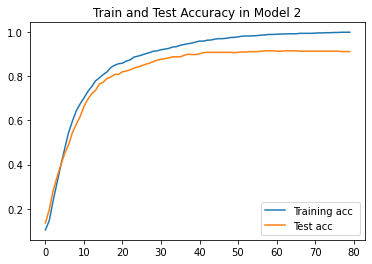

In [13]:
plt.plot(train_acc_2)
plt.plot(all_acc_2)
plt.legend(['Training acc ','Test acc'])
plt.title('Train and Test Accuracy in Model 2')
plt.show()

In [14]:
PATH2 = './cifar_net.pth'
torch.save(net_2.state_dict(), PATH2)

Show some images and their predicted value

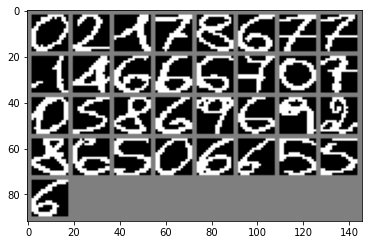

Predicted:  0     2     1     7     8     6     7     7     1     1     6     6     6     7     0     7     0     5     8     6     9     6     9     2     8     6     5     0     6     6     5     5     6    


In [15]:
net_2 = Net()
net_2.load_state_dict(torch.load(PATH2))

outputs = net_2(images)

_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images))

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(predicted.size(dim=0))))


Show the Accuracy of Model 2 and Accuracy in each class.

In [16]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net_2(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of Net_2 on all test images: {100 * correct // total} %')

Accuracy of Net_2 on all test images: 91 %


In [17]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_2(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 98.3 %
Accuracy for class: 1     is 91.9 %
Accuracy for class: 2     is 97.9 %
Accuracy for class: 3     is 85.7 %
Accuracy for class: 4     is 91.2 %
Accuracy for class: 5     is 89.4 %
Accuracy for class: 6     is 95.6 %
Accuracy for class: 7     is 91.2 %
Accuracy for class: 8     is 86.7 %
Accuracy for class: 9     is 83.9 %


##### Conclusion of Model 2

In this mode, the accuracy of Test data is 91%, higher than the Model 1. And it is a very exciting accuracy rate.

The accuray for Class '0' is 98.3%, highest. And the accuracy of Class '9' is the lowest, only 83.9%, lowest.

It seems that for this dataset, we can achieve higher accuracy with a simpler model.

But will this be because Model 1 is not complex enough, so next, let's try to deal this dataset with a model with two Conv layers

### Model 3: CNN model with 2 Convolutional layers and SGD as optimizer.

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 2)
        self.fc1 = nn.Linear(8 * 3 * 3, 180)
        self.fc2 = nn.Linear(180, 90)
        self.fc3 = nn.Linear(90, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net_3 = Net()
net_3 = net_3.to ('cuda')

# Define a Loss function and optimizer
# Let’s use a Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_3.parameters(), lr=0.001, momentum=0.9)

In [19]:
n_epochs = 80
all_acc_3 = []
train_acc_3 = []
for epoch in range(n_epochs):  # loop over the dataset multiple times
    net_3.to('cuda')
    net_3.train()
    running_loss = 0.0
    train_accs=[]
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        accs = (outputs.argmax(dim=-1) == labels.to('cuda')).float().mean()
        train_accs.append(accs)
    train_acc = sum(train_accs) / len(train_accs)
    train_acc_3.append(train_acc.cpu().item())
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] , Accuracy of Training data = {train_acc:.5f}")
            
    net_3.eval()
    net_3.cpu()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net_3(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_3.append(acc)
    print(f'Accuracy of Test data = {100 * correct // total} %')
print('Finished Training')

[ Train | 001/080 ] , Accuracy of Training data = 0.07400
Accuracy of Test data = 11 %
[ Train | 002/080 ] , Accuracy of Training data = 0.08300
Accuracy of Test data = 11 %
[ Train | 003/080 ] , Accuracy of Training data = 0.10300
Accuracy of Test data = 14 %
[ Train | 004/080 ] , Accuracy of Training data = 0.12200
Accuracy of Test data = 14 %
[ Train | 005/080 ] , Accuracy of Training data = 0.13900
Accuracy of Test data = 16 %
[ Train | 006/080 ] , Accuracy of Training data = 0.14900
Accuracy of Test data = 16 %
[ Train | 007/080 ] , Accuracy of Training data = 0.17500
Accuracy of Test data = 16 %
[ Train | 008/080 ] , Accuracy of Training data = 0.19000
Accuracy of Test data = 17 %
[ Train | 009/080 ] , Accuracy of Training data = 0.19800
Accuracy of Test data = 17 %
[ Train | 010/080 ] , Accuracy of Training data = 0.20100
Accuracy of Test data = 18 %
[ Train | 011/080 ] , Accuracy of Training data = 0.20600
Accuracy of Test data = 18 %
[ Train | 012/080 ] , Accuracy of Training 

Show the plot fo Training and Test Accuracy in Model 3

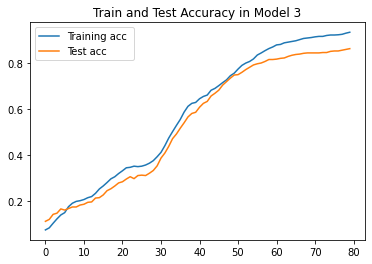

In [20]:
plt.plot(train_acc_3)
plt.plot(all_acc_3)
plt.legend(['Training acc ','Test acc'])
plt.title('Train and Test Accuracy in Model 3')
plt.show()

In [21]:
PATH3 = './cifar_net.pth'
torch.save(net_3.state_dict(), PATH3)

Show some images and their predicted value

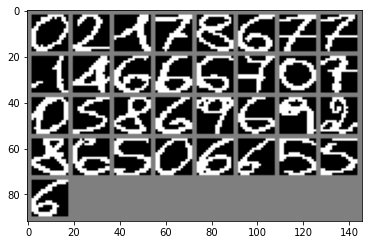

Predicted:  0     2     1     7     9     6     7     7     0     1     6     6     6     7     0     7     0     5     8     4     9     6     9     2     8     6     5     0     6     6     5     5     6    


In [22]:
net_3 = Net()
net_3.load_state_dict(torch.load(PATH2))

outputs = net_3(images)

_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images))

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(predicted.size(dim=0))))

Show the Accuracy of Model 3 and Accuracy in each class.

In [23]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net_3(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of Net_3 on all test images: {100 * correct // total} %')

Accuracy of Net_3 on all test images: 86 %


In [24]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_3(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 96.6 %
Accuracy for class: 1     is 88.7 %
Accuracy for class: 2     is 80.9 %
Accuracy for class: 3     is 80.4 %
Accuracy for class: 4     is 87.7 %
Accuracy for class: 5     is 84.8 %
Accuracy for class: 6     is 88.2 %
Accuracy for class: 7     is 75.4 %
Accuracy for class: 8     is 88.3 %
Accuracy for class: 9     is 88.7 %


##### Conclusion of Model 3

In this mode, the accuracy of Test data is 86%, looks high, but also lower than the accuracy of Model 2.

The accuray for Class '0' is 96.6%, highest. And the accuracy of Class '6' is the lowest, only 75.4%, lowest.

Judging from the trend of accuracy, it still has room for improvement, perhaps because of the smaller number of epochs. But limited by hardware, we can't run more epochs.

Next, let's see if changing the optimizer can make the results better

### Model 4: CNN with 1 Convolutional layer and ASGD as optimizer.

In [25]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(4 * 7 * 7, 180)
        self.fc2 = nn.Linear(180, 90)
        self.fc3 = nn.Linear(90, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net_4 = Net()
net_4 = net_4.to ('cuda')

# Define a Loss function and optimizer
# Let’s use a Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.ASGD(net_4.parameters(), lr=0.001)

In [26]:
n_epochs = 80
all_acc_4 = []
train_acc_4 = []
for epoch in range(n_epochs):  # loop over the dataset multiple times
    net_4.to('cuda')
    net_4.train()
    running_loss = 0.0
    train_accs=[]
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_4(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        accs = (outputs.argmax(dim=-1) == labels.to('cuda')).float().mean()
        train_accs.append(accs)
    train_acc = sum(train_accs) / len(train_accs)
    train_acc_4.append(train_acc.cpu().item())
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] , Accuracy of Training data = {train_acc:.5f}")
            
    net_4.eval()
    net_4.cpu()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net_4(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_4.append(acc)
    print(f'Accuracy of Test data = {100 * correct // total} %')
print('Finished Training')

[ Train | 001/080 ] , Accuracy of Training data = 0.11700
Accuracy of Test data = 14 %
[ Train | 002/080 ] , Accuracy of Training data = 0.11800
Accuracy of Test data = 14 %
[ Train | 003/080 ] , Accuracy of Training data = 0.12000
Accuracy of Test data = 14 %
[ Train | 004/080 ] , Accuracy of Training data = 0.12400
Accuracy of Test data = 14 %
[ Train | 005/080 ] , Accuracy of Training data = 0.12800
Accuracy of Test data = 15 %
[ Train | 006/080 ] , Accuracy of Training data = 0.13200
Accuracy of Test data = 15 %
[ Train | 007/080 ] , Accuracy of Training data = 0.13500
Accuracy of Test data = 15 %
[ Train | 008/080 ] , Accuracy of Training data = 0.13900
Accuracy of Test data = 14 %
[ Train | 009/080 ] , Accuracy of Training data = 0.14300
Accuracy of Test data = 14 %
[ Train | 010/080 ] , Accuracy of Training data = 0.14600
Accuracy of Test data = 13 %
[ Train | 011/080 ] , Accuracy of Training data = 0.14300
Accuracy of Test data = 14 %
[ Train | 012/080 ] , Accuracy of Training 

Show the plot fo Training and Test Accuracy in Model 4

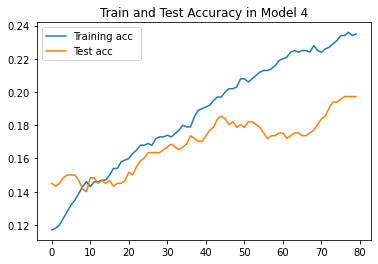

In [27]:
plt.plot(train_acc_4)
plt.plot(all_acc_4)
plt.legend(['Training acc ','Test acc'])
plt.title('Train and Test Accuracy in Model 4')
plt.show()

Show some images and their predicted value

In [28]:
PATH4 = './cifar_net.pth'
torch.save(net_4.state_dict(), PATH4)

Show the Accuracy of Model 4 and Accuracy in each class.

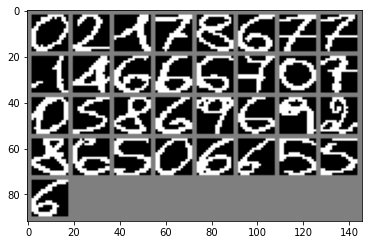

Predicted:  0     2     1     1     1     2     2     2     1     1     2     2     2     2     2     2     2     2     2     2     1     2     2     2     2     6     2     2     2     4     1     2     2    


In [29]:
net_4 = Net()
net_4.load_state_dict(torch.load(PATH4))

outputs = net_4(images)

_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images))

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(predicted.size(dim=0))))

In [30]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net_4(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of Net_4 on all test images: {100 * correct // total} %')

Accuracy of Net_4 on all test images: 19 %


In [31]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_4(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 22.4 %
Accuracy for class: 1     is 74.2 %
Accuracy for class: 2     is 87.2 %
Accuracy for class: 3     is 0.0 %
Accuracy for class: 4     is 24.6 %
Accuracy for class: 5     is 0.0 %
Accuracy for class: 6     is 2.9 %
Accuracy for class: 7     is 0.0 %
Accuracy for class: 8     is 1.7 %
Accuracy for class: 9     is 0.0 %


##### Conclusion of Model 4

This result is very poor, and it seems that for this dataset, using ASGD as the optimizer is very slow to converge. 

Although it seems that increasing the number of epochs can make the results better, it seems like a waste of time.

### Comparison of 4 Models

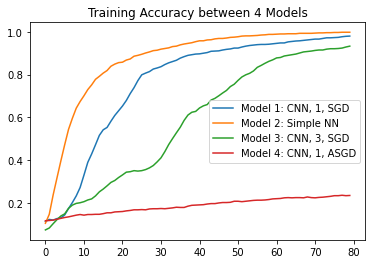

In [32]:
plt.plot(train_acc_1)
plt.plot(train_acc_2)
plt.plot(train_acc_3)
plt.plot(train_acc_4)
plt.legend(['Model 1: CNN, 1, SGD','Model 2: Simple NN', 'Model 3: CNN, 3, SGD', 'Model 4: CNN, 1, ASGD'])
plt.title('Training Accuracy between 4 Models')
plt.show()

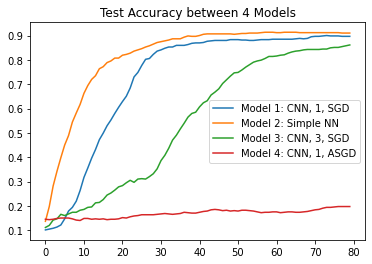

In [33]:
plt.plot(all_acc_1)
plt.plot(all_acc_2)
plt.plot(all_acc_3)
plt.plot(all_acc_4)
plt.legend(['Model 1: CNN, 1, SGD','Model 2: Simple NN', 'Model 3: CNN, 3, SGD', 'Model 4: CNN, 1, ASGD'])
plt.title('Test Accuracy between 4 Models')
plt.show()

### Conclusion

1. Both Model 1, 2 and 3 performs good enough, among them, The accuracy of Model 2 is highest, both of training data or test data.
2. The structure of Model 2 is simplest, so the Model 2 has the fastest speed to run every epoch.
3. Model 2 has the fastest speed of convergence.

##### So, Model 2 —— The Simple Neural Network can be use to do Handwritten Digit Classification.

### Imperfections and some possible improvements

1. Overfitting occurs, which can be solved by reducing the number of epochs or increasing drop out.
2. The accuracy of Model 3 might not convergence, if we add the number of epochs, the accuracy might be better.
3. Limited by hardware, we did not try models with more layers.